In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [3]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of timeseries data: finance.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/finance.csv

--2024-12-12 18:58:42--  https://docs.rockfish.ai/tutorials/finance.csv
Resolving docs.rockfish.ai (docs.rockfish.ai)... 

I0000 00:00:1734058722.399380 8428967 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


2600:9000:285b:ec00:3:1cb5:3480:93a1, 2600:9000:285b:2a00:3:1cb5:3480:93a1, 2600:9000:285b:da00:3:1cb5:3480:93a1, ...
Connecting to docs.rockfish.ai (docs.rockfish.ai)|2600:9000:285b:ec00:3:1cb5:3480:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3444556 (3.3M) [text/csv]
Saving to: ‘finance.csv’

finance.csv         100%[===================>]   3.28M  7.54MB/s    in 0.4s    

2024-12-12 18:58:44 (7.54 MB/s) - ‘finance.csv’ saved [3444556/3444556]



In [5]:
dataset = rf.Dataset.from_csv("finance", "finance.csv")
dataset.to_pandas()

,customer,age,gender,merchant,category,amount,fraud,timestamp
0,C1093826151,4,M,M348934600,transportation,4.55,0,2023-01-01
1,C575345520,2,F,M348934600,transportation,76.67,0,2023-01-01
2,C1787537369,2,M,M1823072687,transportation,48.02,0,2023-01-01
3,C1732307957,5,F,M348934600,transportation,55.06,0,2023-01-01
4,C842799656,1,F,M348934600,transportation,25.62,0,2023-01-01
...,...,...,...,...,...,...,...,...
49995,C1971105040,3,M,M348934600,transportation,67.91,0,2023-01-20
49996,C51444479,3,M,M348934600,transportation,32.27,0,2023-01-20
49997,C1096642744,5,M,M1535107174,wellnessandbeauty,149.70,0,2023-01-20
49998,C1166683343,2,F,M1823072687,transportation,24.78,0,2023-01-20


In [6]:
config = ra.TrainTimeGAN.Config(
    encoder=ra.TrainTimeGAN.DatasetConfig(
        timestamp=ra.TrainTimeGAN.TimestampConfig(field="timestamp"),
        metadata=[
            ra.TrainTimeGAN.FieldConfig(field="customer", type="session"),
            ra.TrainTimeGAN.FieldConfig(field="age", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="gender", type="categorical"),
        ],
        measurements=[
            ra.TrainTimeGAN.FieldConfig(field="merchant", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="category", type="categorical"),
            ra.TrainTimeGAN.FieldConfig(field="amount"),
            ra.TrainTimeGAN.FieldConfig(field="fraud", type="categorical"),
        ],
    ),
    doppelganger=ra.TrainTimeGAN.DGConfig(
        sample_len=19,
        epoch=10,
        epoch_checkpoint_freq=10,
        batch_size=64,
        sessions=3765,
    ),
)

# create train action
train = ra.TrainTimeGAN(config)

In [7]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 5VvFfK868XSldnZmZWb5Ke


In [8]:
async for progress in workflow.progress().notebook():
    pass

I0000 00:00:1734058735.924136 8428967 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
model = await workflow.models().last()
model

Model(id='7b0d6035-b8fe-11ef-b309-ea33642f8b3f', labels={'workflow_id': '5VvFfK868XSldnZmZWb5Ke'}, create_time=datetime.datetime(2024, 12, 13, 3, 0, 59, tzinfo=datetime.timezone.utc), size_bytes=19993600)

In [10]:
generate = ra.GenerateTimeGAN(config)
save = ra.DatasetSave({"name": "synthetic"})
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 6asF6uqkuH01RkSLgBzgL4


In [11]:
async for progress in workflow.progress().notebook():
    pass

  0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)
syn.to_pandas()

,timestamp,amount,age,gender,merchant,category,fraud,session_key
0,2023-01-01 18:04:27.220,234.737122,3,F,M348934600,transportation,0,0.0
1,2023-01-02 19:07:32.924,213.085905,3,F,M348934600,transportation,0,0.0
2,2023-01-03 23:25:51.854,215.547686,3,F,M348934600,transportation,0,0.0
3,2023-01-05 03:43:46.250,169.591732,3,F,M348934600,transportation,0,0.0
4,2023-01-06 09:06:37.358,170.791057,3,F,M348934600,transportation,0,0.0
...,...,...,...,...,...,...,...,...
53937,2023-10-18 00:22:28.467,7245.033097,6,M,M348934600,transportation,0,3764.0
53938,2023-11-10 03:05:36.567,5919.946644,6,M,M348934600,transportation,0,3764.0
53939,2023-11-29 01:48:12.863,5615.543164,6,M,M348934600,transportation,0,3764.0
53940,2023-12-18 06:22:18.610,6839.082788,6,M,M1823072687,transportation,0,3764.0


### Evaluation


In [13]:
source_data = rf.Dataset.from_pandas("source", dataset.to_pandas())
syn_data = rf.Dataset.from_pandas(
    "rf-dg", syn.to_pandas().rename(columns={"session_key": "customer"})
)
schema_metadata = rf.arrow.SchemaMetadata(
    metadata=["customer", "age", "gender"]
)
source_data.table = rf.arrow.replace_schema_metadata(
    source_data.table, schema_metadata
)
syn_data.table = syn_data.table.select(source_data.table.column_names)
syn_data.table = rf.arrow.replace_schema_metadata(
    syn_data.table, schema_metadata
)

syn_data.table = syn_data.table.cast(source_data.table.schema, safe=False)

**1. session length**


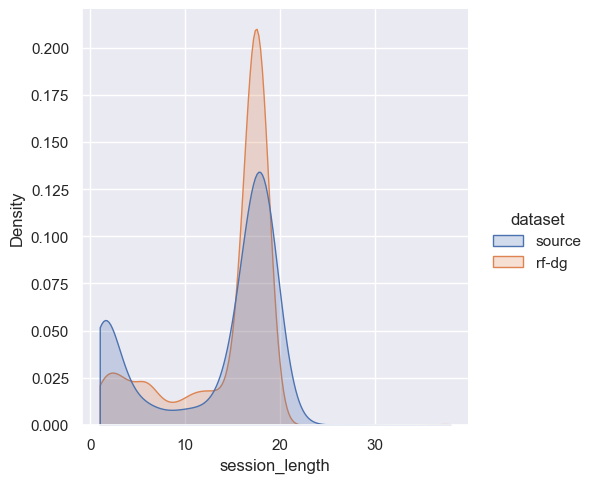

In [14]:
source_sess = rf.metrics.session_length(source_data)
syn_sess = rf.metrics.session_length(syn_data)
rf.labs.vis.plot_kde([source_sess, syn_sess], "session_length")

**2. interarrival time**

Here the unit for duration is in seconds


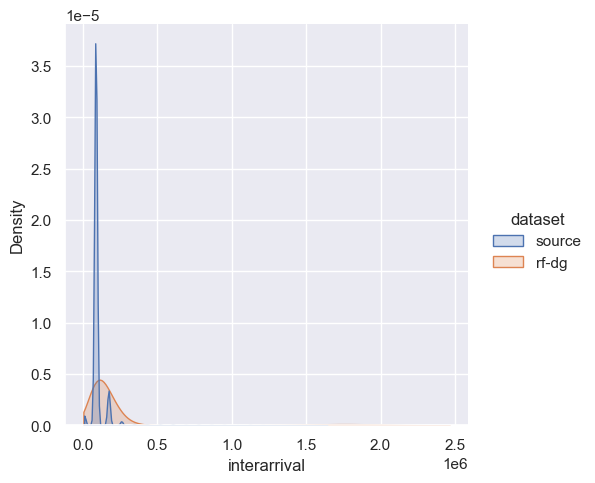

In [15]:
timestamp = "timestamp"
source_interarrival = rf.metrics.interarrivals(source_data, timestamp)
syn_interarrival = rf.metrics.interarrivals(syn_data, timestamp)
rf.labs.vis.plot_kde(
    [source_interarrival, syn_interarrival], "interarrival", duration_unit="s"
)

**3. numerical columns**


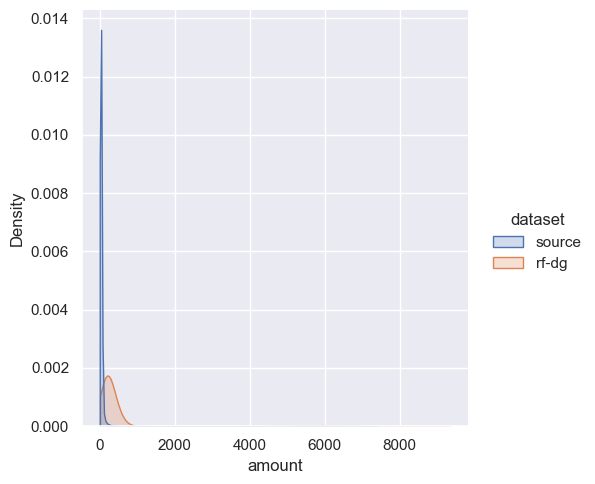

In [16]:
rf.labs.vis.plot_kde([source_data, syn_data], "amount")

**4. categorical columns**

If there is a large categorical column containing over 10 categories, we plot the Top10 bars for users to compare.

NB. If you want to show more than Top10, update the number of `nlargest`


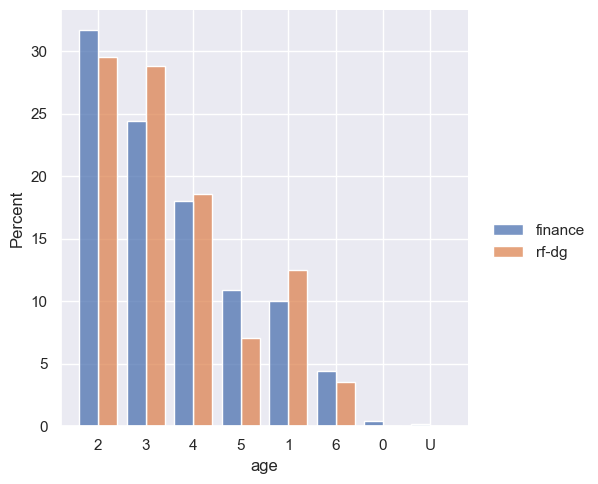

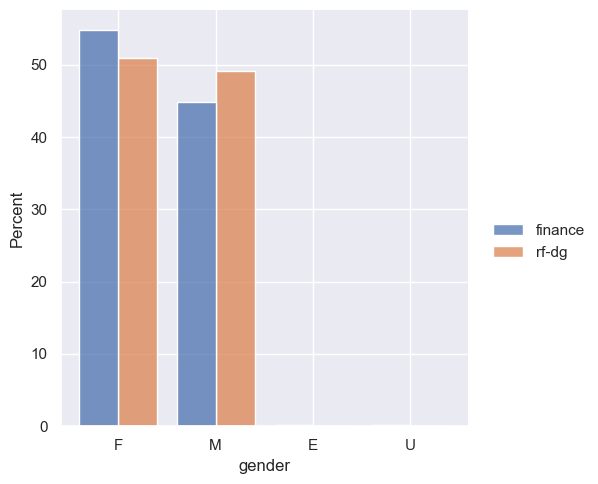

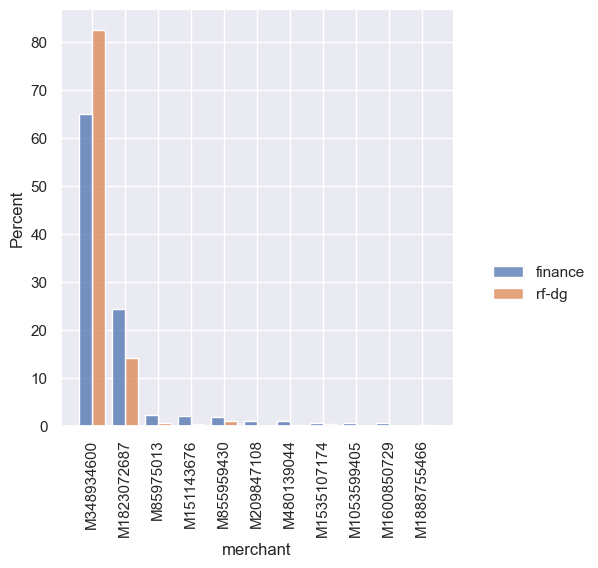

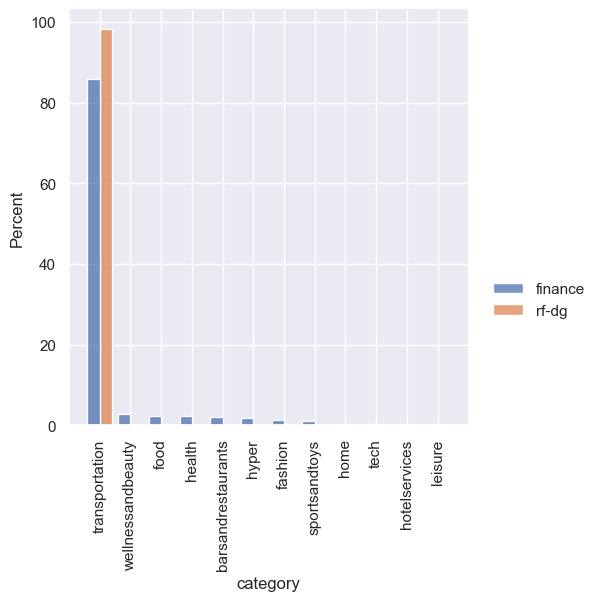

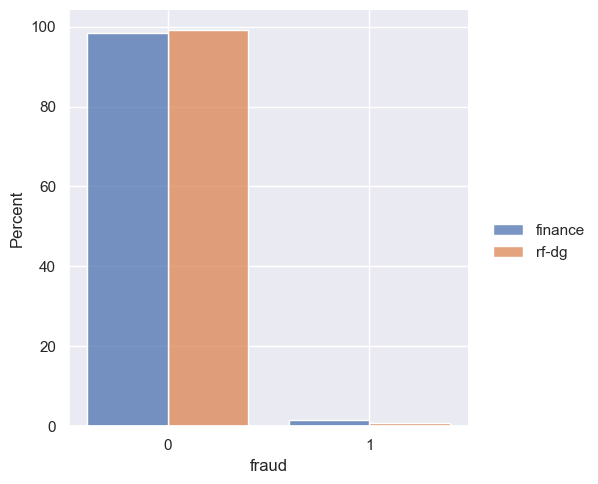

In [17]:
for col in ["age", "gender", "merchant", "category", "fraud"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn_data, col, nlargest=10)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")